In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier # horrible because inbalanced classes
from sklearn.linear_model import LogisticRegression # sucks
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import NuSVC
from sklearn.svm import SVC
import shlex
import subprocess
import sys
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, TorsionFingerprints
from rdkit.Chem import Descriptors
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.AtomPairs import Torsions
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import Draw
from multiprocessing import Pool
import math
import timeit
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from e3fp.fingerprint.generate import fp, fprints_dict_from_mol
# from e3fp.conformers.generate import generate_conformers
from e3fp.pipeline import fprints_from_smiles
import cirpy
%run MontyCarlo.ipynb
import random
random.seed(0)

In [3]:
df = pd.read_excel('SixC-Ring SMILES final chemical library.xlsx')
df.drop(columns=df.columns[3:],inplace=True)
df.columns = ['smiles', 'names', 'label']
df['label'] = [i[0] == 'a' for i in df['label']]


bits = int(2048)

smiles = df['smiles']
names = df['names']
molecs = [Chem.MolFromSmiles(i) for i in smiles]
[i.SetProp("_Name",j) for i,j in zip(molecs,names)]
molecs = [i for i in molecs if not i == None]

fingerprintM = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,nBits=bits) for i in molecs])
fingerprintA = np.array([pyAvalonTools.GetAvalonFP(i,nBits=bits) for i in molecs])
fingerprintT = np.array([SimilarityMaps.GetRDKFingerprint(i,nBits=bits) for i in molecs])


label = df['label']
tot = len(label)
pos = sum(label)
neg = tot - sum(label)




# print(df)
print(f"FULL Dataset: {df.shape}")
fingerprint = np.hstack((
    fingerprintM,
    fingerprintA,
    fingerprintT,
))

print("Fingerprint:",fingerprint.shape,"Sparcity:",np.mean(fingerprint))


FULL Dataset: (173, 3)
Fingerprint: (173, 6144) Sparcity: 0.03584116088631985


# Scoring the catalog

Training model!
Model trained!
Largest error on training data: 1.0


RDKit WARNING: [16:59:21] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [16:59:21] SMILES Parse Error: syntax error while parsing: [Cu+]|1|2|3|4|OC(C)O|[Cu++]|5|6(|OC(C)O|1)|O|2c7c(CN8|5CCN|6(C)CC8)cc(cc7CN9|3CCN|4(C)CC9)C#N
RDKit ERROR: [16:59:21] SMILES Parse Error: Failed parsing SMILES '[Cu+]|1|2|3|4|OC(C)O|[Cu++]|5|6(|OC(C)O|1)|O|2c7c(CN8|5CCN|6(C)CC8)cc(cc7CN9|3CCN|4(C)CC9)C#N' for input: '[Cu+]|1|2|3|4|OC(C)O|[Cu++]|5|6(|OC(C)O|1)|O|2c7c(CN8|5CCN|6(C)CC8)cc(cc7CN9|3CCN|4(C)CC9)C#N'
RDKit WARNING: [16:59:21] WARNING: not removing hydrogen atom without neighbors
[16:59:21] WARNING: not removing hydrogen atom without neighbors
[16:59:21] SMILES Parse Error: syntax error while parsing: [Cu+]|1|2|3|4|OC(C)O|[Cu++]|5|6(|OC(C)O|1)|O|2c7c(CN8|5CCN|6(C)CC8)cc(cc7CN9|3CCN|4(C)CC9)C#N
[16:59:21] SMILES Parse Error: Failed parsing SMILES '[Cu+]|1|2|3|4|OC(C)O|[Cu++]|5|6(|OC(C)O|1)|O|2c7c(CN8|5CCN|6(C)CC8)cc(cc7CN9|3CCN|4(C)CC9)C#N' for input: '[Cu+]|1|2|3|4|OC(C)O|[Cu++

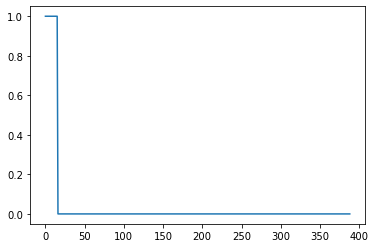

In [4]:
model = SGDClassifier(random_state=0,loss='log', validation_fraction=sys.float_info.min, penalty='elasticnet')
print('Training model!')
model.fit(fingerprint,label)
print('Model trained!')
# df = pd.read_excel('StockListCarbohydratesFiltered.xlsx')
df = pd.read_csv('StockListCarbohydratesCirpy.csv')
# print(df)
def run_on_one(s):
    s = Chem.MolFromSmiles(s)
    if s == None:
        return 0
    else:
        # fingerprintM = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,useChirality=True,nBits=bits) for i in molecs])
        fingerprintM = list(AllChem.GetMorganFingerprintAsBitVect(s,2,nBits=bits))
        fingerprintA = list(pyAvalonTools.GetAvalonFP(s,nBits=bits))
        fingerprintT = list(SimilarityMaps.GetRDKFingerprint(s,nBits=bits))

        fingerprint = [fingerprintM + fingerprintA + fingerprintT]
        # fingerprint = [fingerprintM]
        return model.predict_proba(fingerprint)[0][1]
def model_on_list(x):
    pool = Pool(16)
    result = list(pool.map(run_on_one,x))
    pool.close()
    pool.join()
    return result

train_reslt = model_on_list(smiles)
predictions = np.array(train_reslt) - np.array(label)
print('Largest error on training data:',max(abs(predictions)))


inp = list(df['SMILES'])
predictions = list(zip(model_on_list(inp),df['Name'],df['SMILES']))
predictions.sort(reverse=True)

plt.plot([i[0] for i in predictions])
plt.show()

hits: 16
CNCC(O)C(O)C(O)C(O)CO
OC[C@@H]1OC(O)(CO)[C@H](O)[C@H]1O
OCC1(O)OC[C@@H](O)[C@H](O)[C@@H]1O
OCC1(O)OC[C@@H](O)[C@H](O)[C@H]1O
OCC1(O)OC[C@@H](O)[C@@H](O)[C@H]1O
NCC(O)C(O)C(O)C(O)CO
O.O.O.O.O.O.O.O.[Na+].[Na+].[Na+].O[C@H]1[C@H](O)C(O)(CO[P]([O-])([O-])=O)O[C@@H]1CO[P]([O-])([O-])=O
OCC1OC(O)CC(O)C1O
CCCCCCCCNC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
OCC1OC(O)C(O)C(O)C1O
OCC1OC(O)C(O)C(O)C1O
OCC1OC(O)C(O)C(O)C1O
OCC1OC(O)C(O)C(O)C1O
OCC1OC(O)C(O)C(O)C1O
OC[C@H]1OC(O)[C@H](O)[C@H](O)[C@@H]1O
OC[C@H]1O[C@H](OC[C@H]2OC(O)(CO)[C@@H](O)[C@@H]2O)[C@H](O)[C@@H](O)[C@@H]1O


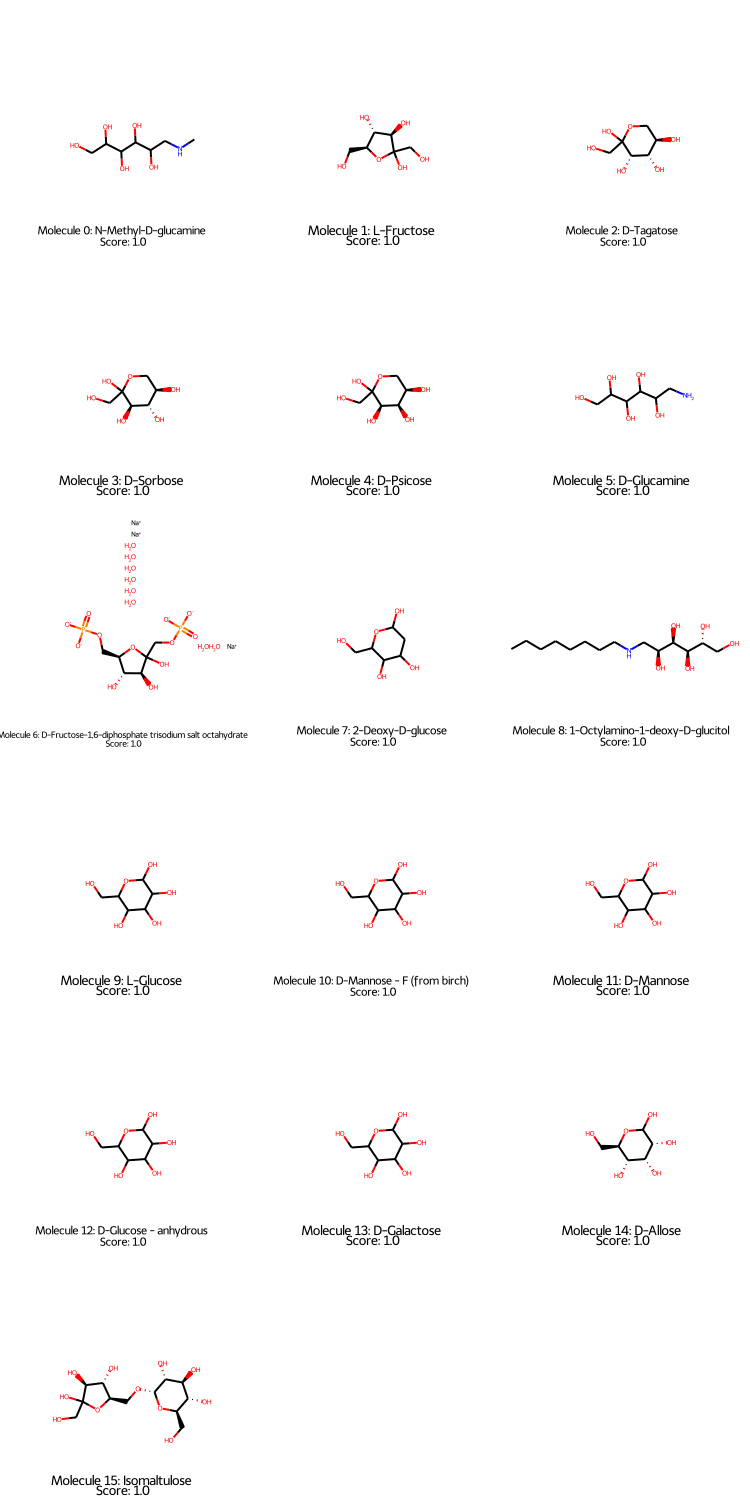

In [5]:
posatives = [i for i in predictions if i[0] > 0.5]
print(f"hits: {len(posatives)}")
print('\n'.join([i[2] for i in posatives]))


mMols = [Chem.MolFromSmiles(m[2]) for m in posatives]
Draw.MolsToGridImage(mMols,legends=[f'Molecule {x}: {i[1]}\nScore: {round(i[0],2)}' + (i[2] in smiles)*'\nin training' for x,i in enumerate(posatives)], subImgSize=(250,250), useSVG=False)
